In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


  cat     bird     frog    truck     deer     bird     frog     bird


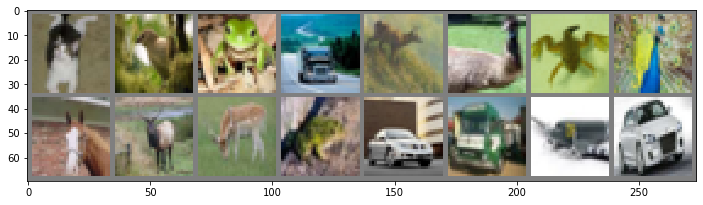

horse     deer     deer     frog    automobile    truck    airplane    automobile


In [4]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(12, 4))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
print('    '.join('%5s' % trainset.classes[labels[j]] for j in range(0,int(batch_size/2))))
imshow(torchvision.utils.make_grid(images))
print('    '.join('%5s' % trainset.classes[labels[j]] for j in range(int(batch_size/2),batch_size)))

In [5]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
NUM_CLASSES = len(trainset.classes)
NUM_CLASSES

10

In [8]:
epoch_load = 100
model_lenet = LeNet5(NUM_CLASSES)
model_lenet.to(device)
model_lenet.load_state_dict(torch.load("trained_models/LeNet_tiny__900.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
def calculate_accuracy(model, loader):
    total = 0
    correct = 0
    for i, (x, label) in enumerate(loader):
        logits = model(x.to(device))
        conf, preds = logits.topk(1)
        correct += (label.to(device) == preds.squeeze(1)).sum()
        total +=label.size(0)
    return (100*correct/total).item()

In [10]:
calculate_accuracy(model_lenet, testloader)

49.88999938964844

In [12]:
def calculate_ece(logits, labels, n_bins=10):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, device=logits.device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece.item()

In [18]:
def make_model_diagrams(outputs, labels, n_bins=10):
    """
    outputs - a torch tensor (size n x num_classes) with the outputs from the final linear layer
    - NOT the softmaxes
    labels - a torch tensor (size n) with the labels
    """
    softmaxes = torch.nn.functional.softmax(outputs, 1)
    confidences, predictions = softmaxes.max(1)
    accuracies = torch.eq(predictions, labels)
    overall_accuracy = (predictions==labels).sum().item()/len(labels)
    # Reliability diagram
    bins = torch.linspace(0, 1, n_bins + 1)
    width = 1.0 / n_bins
    bin_centers = np.linspace(0, 1.0 - width, n_bins) + width / 2
    bin_indices = [confidences.ge(bin_lower) * confidences.lt(bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    
    bin_corrects = np.array([ torch.mean(accuracies[bin_index].float()) for bin_index in bin_indices],dtype=float)
    bin_scores = np.array([ torch.mean(confidences[bin_index].float()) for bin_index in bin_indices], dtype=float)
     
    plt.figure(0, figsize=(8, 8))
    gap = (np.nan_to_num(bin_scores) - np.nan_to_num(bin_corrects))
    confs = plt.bar(bin_centers, bin_corrects, width=width, alpha=0.1, ec='black')
    #gaps = plt.bar(bin_centers, gap, bottom=np.nan_to_num(bin_corrects), color=[1, 0.7, 0.7], alpha=0.5, width=width, hatch='//', edgecolor='r')
    gaps = plt.bar(bin_centers, gap, bottom=np.nan_to_num(bin_corrects), color=[1, 0.7, 0.7], alpha=0.5, width=width, hatch='//', edgecolor='r')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.legend([confs, gaps], ['Outputs', 'Gap'], loc='best', fontsize='small')

    ece = calculate_ece(outputs, labels, n_bins)

    # Clean up
    bbox_props = dict(boxstyle="round", fc="lightgrey", ec="brown", lw=2)
    plt.text(0.2, 0.85, "ECE: {:.2f}".format(ece), ha="center", va="center", size=20, weight = 'bold', bbox=bbox_props)

    plt.title("Reliability Diagram", size=20)
    plt.ylabel("Accuracy (P[y]",  size=18)
    plt.xlabel("Confidence",  size=18)
    plt.xlim(0,1)
    plt.ylim(0,1)
    return ece

0.42822620272636414

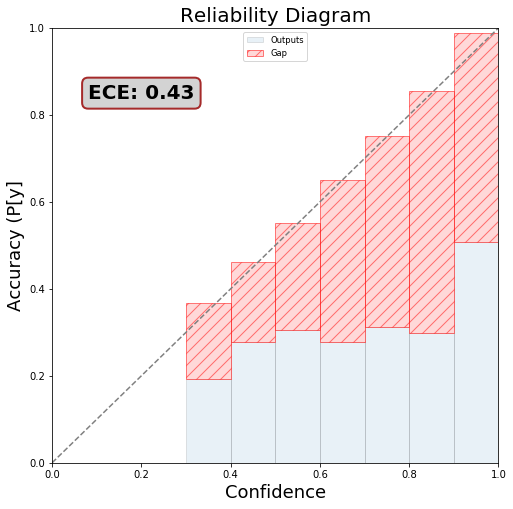

In [19]:
logits = torch.stack([model_lenet(x[0].to(device)) for x in testloader])
labs = torch.stack([x[1].to(device) for x in testloader])
labs = labs.view(-1)
logits = logits.view(-1,NUM_CLASSES)
make_model_diagrams(logits, labs, n_bins=10)

### ResNET

In [20]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [21]:
!ls trained_models/

LeNet_tiny__0.pt     LeNet_tiny__400.pt  resnet_2_110_100.pt
LeNet_tiny__100.pt   LeNet_tiny__500.pt  resnet_2_110_200.pt
LeNet_tiny__1000.pt  LeNet_tiny__600.pt  resnet_2_110_focal_0.pt
LeNet_tiny__1100.pt  LeNet_tiny__700.pt  resnet_2_110_focal_100.pt
LeNet_tiny__1200.pt  LeNet_tiny__800.pt  resnet_2_110_focal_165.pt
LeNet_tiny__1300.pt  LeNet_tiny__900.pt  wideresnet_28_0.pt
LeNet_tiny__1400.pt  resnet_110__0.pt	 wideresnet_28_100.pt
LeNet_tiny__200.pt   resnet_110__100.pt  wideresnet_2_28_0.pt
LeNet_tiny__300.pt   resnet_2_110_0.pt	 wideresnet_2_28_100.pt


In [22]:
model_resnet = ResNet(BasicBlock, [18, 18, 18])
model_resnet.to(device)
model_resnet.load_state_dict(torch.load("trained_models/resnet_2_110_200.pt", map_location=torch.device('cpu')))
calculate_accuracy(model_resnet, testloader)

83.95999908447266

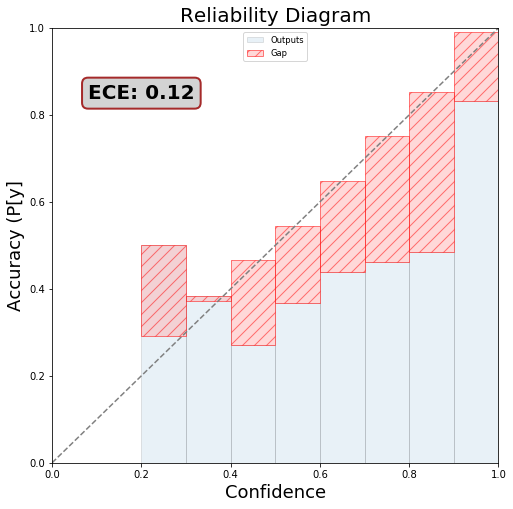

In [24]:
with torch.no_grad():
    logits = torch.stack([model_resnet(x[0].to(device)) for x in testloader])
    labs = torch.stack([x[1].to(device) for x in testloader])
    labs = labs.view(-1)
    logits = logits.view(-1,NUM_CLASSES)
    make_model_diagrams(logits, labs, n_bins=10)

In [25]:
!ls -lah trained_models/

total 616M
drwxrwxr-x  2 roberto roberto 4.0K Mar 23 13:46 .
drwxrwxr-x 12 roberto roberto 4.0K Mar 23 14:00 ..
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:07 LeNet_tiny__0.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:19 LeNet_tiny__100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:07 LeNet_tiny__1000.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:19 LeNet_tiny__1100.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:31 LeNet_tiny__1200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:44 LeNet_tiny__1300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 14:56 LeNet_tiny__1400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:31 LeNet_tiny__200.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:43 LeNet_tiny__300.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 12:55 LeNet_tiny__400.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:07 LeNet_tiny__500.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:19 LeNet_tiny__600.pt
-rw-rw-r--  1 roberto roberto 246K Nov  1 13:31 LeNet_tiny__700.pt
-rw-rw-r--  1 

In [26]:
model_resnet_focal = ResNet(BasicBlock, [18, 18, 18])
model_resnet_focal.to(device)
model_resnet_focal.load_state_dict(torch.load("trained_models/resnet_2_110_focal_165.pt", map_location=torch.device('cpu')))
calculate_accuracy(model_resnet_focal, testloader)

80.58999633789062

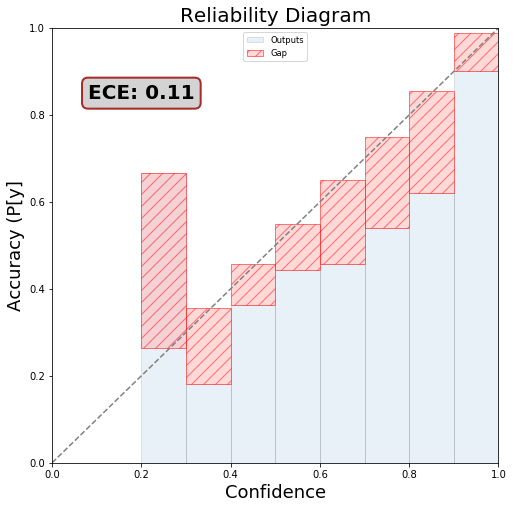

In [27]:
with torch.no_grad():
    logits = torch.stack([model_resnet_focal(x[0].to(device)) for x in testloader])
    labs = torch.stack([x[1].to(device) for x in testloader])
    labs = labs.view(-1)
    logits = logits.view(-1,NUM_CLASSES)
    make_model_diagrams(logits, labs, n_bins=10)

## Temperature Scaling

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        soft_logits = F.softmax(logits)
        temp_logits = self.temperature_scale(logits)
        temp_softmax = F.softmax(temp_logits)
        return temp_logits

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        self.bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = self.bin_boundaries[:-1]
        self.bin_uppers = self.bin_boundaries[1:]
        self.bin_width = 1.0 / n_bins
        self.bin_centers = np.linspace(0, 1.0 - self.bin_width, n_bins) + self.bin_width / 2

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
        ece = torch.zeros(1, device=logits.device)
        self.avg_confidences = []
        self.accuracy_in_bin = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                self.avg_confidences.append(avg_confidence_in_bin.detach().cpu().numpy().item())
                self.accuracy_in_bin.append(accuracy_in_bin.detach().cpu().numpy().item())
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        #self.plot_reliability(ece)
        self.ece = ece
        return ece

    def plot_reliability(self):
      plt.figure(0, figsize=(8, 8))
      plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect Calibration")
      plt.bar(self.bin_centers, self.avg_confidences, color='g', width=self.bin_width, align='center', alpha=0.2, ec='black')
      plt.bar(self.bin_centers, self.accuracy_in_bin, color='C1', width=self.bin_width, align='center', alpha=0.5, ec='black')
      plt.xlim(0,1)
      plt.ylim(0,1)
      plt.title("Reliability Diagram", size=20)
      plt.ylabel("Accuracy (P[y]",  size=18)
      plt.xlabel("Confidence",  size=18)
      bbox_props = dict(boxstyle="round", fc="lightgrey", ec="brown", lw=2)
      plt.text(0.2, 0.9, "ECE: {:.2f}".format(self.ece.item()), ha="center", va="center", size=20, weight = 'bold', bbox=bbox_props)
      return None

In [ ]:
temperature_model = ModelWithTemperature(trained_model)


In [ ]:
temperature_model.set_temperature(valid_loader)

In [ ]:
pred_classes = np.array([get_reply_proba(x[0], temperature_model)[0] for x in test_sentences]).squeeze(1)
pred_confidence = np.array([get_reply_proba(x[0], temperature_model)[1] for x in test_sentences]).squeeze(1)
pred_logits = torch.tensor([get_reply_proba(x[0], temperature_model)[3] for x in test_sentences]).squeeze(1)

In [ ]:
type)